In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from datasets import load_dataset

In [5]:
# load dataset
dataset = load_dataset("Matthijs/snacks")
print(dataset)

Generating train split:   0%|          | 0/4838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/952 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})


In [6]:
print(dataset['train'].features['label'].names)

['apple', 'banana', 'cake', 'candy', 'carrot', 'cookie', 'doughnut', 'grape', 'hot dog', 'ice cream', 'juice', 'muffin', 'orange', 'pineapple', 'popcorn', 'pretzel', 'salad', 'strawberry', 'waffle', 'watermelon']


In [7]:
# Mapping from label to index and vice versa
labels = dataset['train'].features['label'].names
num_labels = len(dataset['train'].features['label'].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'apple': 0, 'banana': 1, 'cake': 2, 'candy': 3, 'carrot': 4, 'cookie': 5, 'doughnut': 6, 'grape': 7, 'hot dog': 8, 'ice cream': 9, 'juice': 10, 'muffin': 11, 'orange': 12, 'pineapple': 13, 'popcorn': 14, 'pretzel': 15, 'salad': 16, 'strawberry': 17, 'waffle': 18, 'watermelon': 19}
{0: 'apple', 1: 'banana', 2: 'cake', 3: 'candy', 4: 'carrot', 5: 'cookie', 6: 'doughnut', 7: 'grape', 8: 'hot dog', 9: 'ice cream', 10: 'juice', 11: 'muffin', 12: 'orange', 13: 'pineapple', 14: 'popcorn', 15: 'pretzel', 16: 'salad', 17: 'strawberry', 18: 'waffle', 19: 'watermelon'}


Project our input image into a convolutional layer with the kernel size and stride equal to the patch size. Then, we flatten the output from that convolutional layer.

In [8]:
import torch
import torch.nn as nn
# create toy image with dims (batch x channel x width x height)
toy_img = torch.rand(1, 3, 48, 48)
# define conv layer parameters
nums_channels = 3
hidden_size = 768 #the size of these token embeddings
patch_size = 16

#Conv 2D layer
projection = nn.Conv2d(nums_channels, hidden_size, kernel_size= patch_size, stride= patch_size)

#forward pass toy img
out_projection = projection(toy_img)

print(f'Original image size: {toy_img.size()}')
print(f'Size after projection: {out_projection.size()}')

Original image size: torch.Size([1, 3, 48, 48])
Size after projection: torch.Size([1, 768, 3, 3])


The "emb_dimension" parameter determines the size of these token embeddings. A larger "emb_dimension" implies that each token embedding will have a higher dimensionality, potentially capturing more complex features from the input image patches.

In [9]:
patch_embeddings = out_projection.flatten(2).transpose(1,2)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 9, 768])


In [10]:
batch_size = 1
cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
cls_tokens = cls_token.expand(batch_size, -1 , -1)

#prepend [CLS] token in the beginning of patch embedding
patch_embeddings = torch.cat((cls_tokens, patch_embeddings), dim=1)
print(f'Patch embedding size: {patch_embeddings.size()}')


Patch embedding size: torch.Size([1, 10, 768])


In [11]:
# define position embedding with the same dimension as the patch embedding

position_embeddings = nn.Parameter(torch.randn(batch_size, 10, hidden_size))

#add position embedding into patch embedding
input_embeddings = patch_embeddings + position_embeddings
print(f'Input embedding size: {input_embeddings.size()}')

Input embedding size: torch.Size([1, 10, 768])


In [12]:
num_heads = 12
num_layers = 12

# define transformer encoders' stack

transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model= hidden_size, nhead= num_heads, dim_feedforward= int(hidden_size * 4), dropout= 0.1)
transformer_encoder = nn.TransformerEncoder(encoder_layer= transformer_encoder_layer, num_layers= num_layers)

output_embedding = transformer_encoder(input_embeddings)
print(f' Output embedding size: {output_embedding.size()}')

 Output embedding size: torch.Size([1, 10, 768])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
from transformers import ViTModel

#load pretrained model
model_checkpoint = 'google/vit-base-patch16-224-in21k'
model = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer = False)

#example input image

input_img = torch.rand(batch_size, nums_channels, 224, 224)

# Forward pass input image
output_embedding = model(input_img)
print(output_embedding)
print(f"Output embedding size: {output_embedding['last_hidden_state'].size()}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.1661, -0.1693,  0.0656,  ...,  0.1451,  0.0525, -0.3450],
         [ 0.1996, -0.0389,  0.0172,  ..., -0.0544,  0.1148, -0.3355],
         [ 0.1495, -0.1555,  0.0198,  ..., -0.0229,  0.1847, -0.4890],
         ...,
         [ 0.2383, -0.0120, -0.0505,  ..., -0.1014,  0.1182, -0.4262],
         [ 0.2482, -0.0511,  0.0234,  ..., -0.0950,  0.1480, -0.4092],
         [ 0.2426, -0.0582,  0.0323,  ..., -0.0892,  0.1116, -0.2889]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)
Output embedding size: torch.Size([1, 197, 768])


In [14]:
num_labels = 20

# Define linear classifier layer
classifier = nn.Linear(hidden_size, num_labels)

# Forward pass on the output embedding of [CLS] token
output_classification = classifier(output_embedding['last_hidden_state'][:, 0, :])
print(f"Output embedding size: {output_classification.size()}")

Output embedding size: torch.Size([1, 20])


In [15]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

#Pretrained model checkpoint
model_checkpoint = 'google/vit-base-patch16-224-in21k'


In [16]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):

      self.input_data = input_data
      # Transform input data
      self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

  def __len__(self):
      return len(self.input_data)

  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])

  def get_labels(self, idx):
      return self.input_data[idx]['label']

  def __getitem__(self, idx):
      # Get input data in a batch
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels

In [17]:
class ViT(nn.Module):

  def __init__(self, config=ViTConfig(), num_labels=20,
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels)
        )

  def forward(self, x):

    x = self.vit(x)['last_hidden_state']
    # Use the embedding of [CLS] token
    output = self.classifier(x[:, 0, :])

    return output


In [18]:
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load nodel, loss function, and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_dataset = ImageDataset(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, shuffle=True)

    # Fine tuning loop
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')
            # Save the trained model
    torch.save(model.state_dict(), '/content/drive/My Drive/trained_model.pth')

    return model

# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 8

# Train the model
trained_model = model_train(dataset['train'], EPOCHS, LEARNING_RATE, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/605 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarn

Epochs: 1 | Loss:  0.123 | Accuracy:  0.835


100%|██████████| 605/605 [02:51<00:00,  3.53it/s]


Epochs: 2 | Loss:  0.031 | Accuracy:  0.943


100%|██████████| 605/605 [02:51<00:00,  3.54it/s]


Epochs: 3 | Loss:  0.018 | Accuracy:  0.962


100%|██████████| 605/605 [02:51<00:00,  3.54it/s]


Epochs: 4 | Loss:  0.015 | Accuracy:  0.970


100%|██████████| 605/605 [02:51<00:00,  3.53it/s]


Epochs: 5 | Loss:  0.012 | Accuracy:  0.975


100%|██████████| 605/605 [02:51<00:00,  3.54it/s]


Epochs: 6 | Loss:  0.012 | Accuracy:  0.976


100%|██████████| 605/605 [02:51<00:00,  3.53it/s]


Epochs: 7 | Loss:  0.010 | Accuracy:  0.976


100%|██████████| 605/605 [02:51<00:00,  3.53it/s]


Epochs: 8 | Loss:  0.011 | Accuracy:  0.974


100%|██████████| 605/605 [02:51<00:00,  3.53it/s]


Epochs: 9 | Loss:  0.007 | Accuracy:  0.984


100%|██████████| 605/605 [02:51<00:00,  3.54it/s]


Epochs: 10 | Loss:  0.006 | Accuracy:  0.990


In [19]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [20]:
print(predict(dataset['test'][900]['image']))


waffle


In [27]:
from PIL import Image

def predict(img_path):
    # Load image
    img = Image.open(img_path).convert('RGB')

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

# Example
predicted_class = predict("/content/drive/My Drive/cake.jpg")
print("Predicted class:", predicted_class)


Predicted class: cake


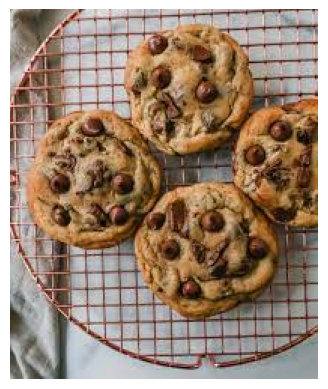

Predicted class: cookie


In [41]:
from PIL import Image
import matplotlib.pyplot as plt


def predict(img_path):
    # Load image
    img = Image.open(img_path).convert('RGB')

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]


# Open the image
img = Image.open("/content/drive/My Drive/cookies.jpeg")

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# Example
predicted_class = predict("/content/drive/My Drive/cookies.jpeg")
print("Predicted class:", predicted_class)


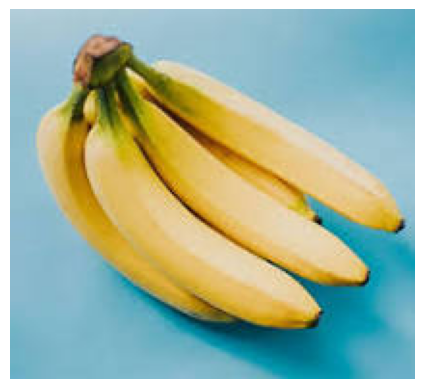

Predicted class: banana


In [38]:
# Open the image
img = Image.open("/content/drive/My Drive/images.jpeg")

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()
# Example
predicted_class = predict("/content/drive/My Drive/images.jpeg")
print("Predicted class:", predicted_class)


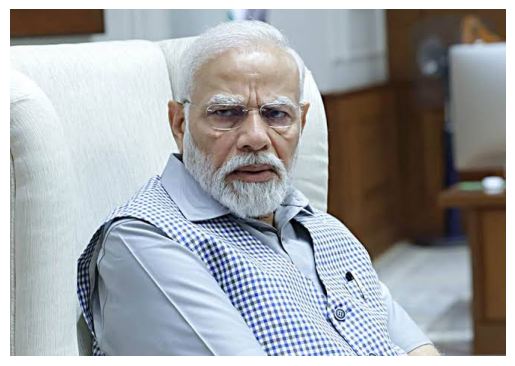

Predicted class: cookie


In [39]:
# Open the image
img = Image.open("/content/drive/My Drive/images_modi .jpeg")

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()
# Example
predicted_class = predict("/content/drive/My Drive/images_modi .jpeg")
print("Predicted class:", predicted_class)


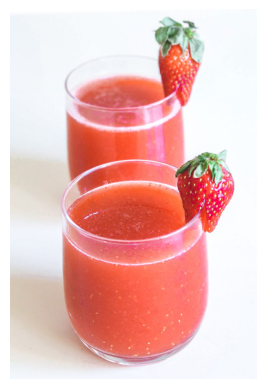

Predicted class: juice


In [40]:
# Open the image
img = Image.open("/content/drive/My Drive/juice.jpeg")

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()
# Example
predicted_class = predict("/content/drive/My Drive/juice.jpeg")
print("Predicted class:", predicted_class)

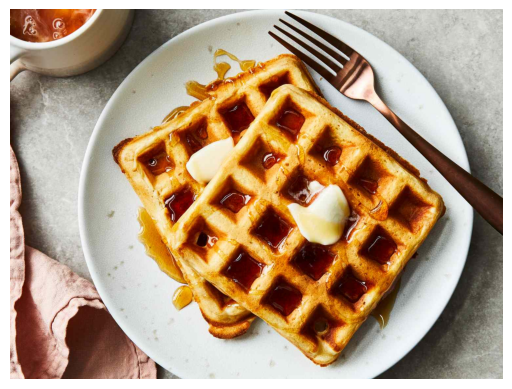

Predicted class: waffle


In [42]:
# Open the image
img = Image.open("/content/drive/My Drive/waffles_1.jpeg")

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()
# Example
predicted_class = predict("/content/drive/My Drive/waffles_1.jpeg")
print("Predicted class:", predicted_class)